In [1]:
import timm
import torch
import wandb
import fastai
from fastai.callback.wandb import WandbCallback
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *

In [2]:
config = SimpleNamespace(
    batch_size=8,
    img_size=224,
    seed=42,
    pretrained=True,
    model_name="maxvit_rmlp_small_rw_224.sw_in1k", # try with maxvit_nano_rw_256.sw_in1k # regnetx_040 coatnet_bn_0_rw_224.sw_in1k
    epochs=5)

def get_images(dataset_path, batch_size, img_size, seed):
    "The beetles dataset"
    files = get_image_files(path=dataset_path, recurse=True, folders=('train','valid'))
    # dls = ImageDataLoaders.from_name_re(dataset_path, files, 
    #                                     pat=r'(^[a-zA-Z]+_*[a-zA-Z]+)', 
    #                                     valid_pct=0.2, 
    #                                     seed=seed, 
    #                                     bs=batch_size,
    #                                     item_tfms=Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'))
    
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
                       get_y = parent_label,
                       # get_y = RegexLabeller(pat = r'([a-zA-Z]+_[a-zA-Z]+)(?=[^\/]+$)'),
                       item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'))
    dls = dblock.dataloaders(dataset_path, bs = batch_size) # [os.path.join(dataset_path,'train'), os.path.join(dataset_path,'valid')]
    return dls

def train(config, dataset_path):
    "Train the model using the supplied config"
    dls = get_images(dataset_path=dataset_path, batch_size=config.batch_size, img_size=config.img_size, seed=config.seed)
    with wandb.init(project="PROJECT", group='ambrosia_symbiosis', job_type='test_training', config=config):
        cbs = [MixedPrecision(), WandbCallback(log='all')]
        learn = vision_learner(dls, 
                               config.model_name, 
                               loss_func=LabelSmoothingCrossEntropyFlat(),
                               metrics=[error_rate, 
                                        accuracy, 
                                        top_k_accuracy], 
                               cbs=cbs, pretrained=config.pretrained)
        learn.fine_tune(config.epochs)
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix()
        interp.plot_top_losses(5, nrows=5)

wandb: Currently logged in as: christopher-marais. Use `wandb login --relogin` to force relogin


C:\Users\GCM\anaconda3\envs\BC_310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.029723,2.795801,0.763158,0.236842,0.771930,03:13


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.773321,3.285543,0.815789,0.184211,0.833333,04:18
1,0.669387,2.850313,0.833333,0.166667,0.833333,04:15
2,0.581295,2.297000,0.789474,0.210526,0.842105,04:18
3,0.564035,2.316269,0.824561,0.175439,0.842105,04:26
4,0.557927,2.423910,0.824561,0.175439,0.807018,04:21


accuracy,█▃▁▅▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,▁▆█▄▇▇
lr_0,▁▂▃▅▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▅▆▇█▂▂▂▃▃▃▄▄▄▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▆▄▃▂▁██▇▆▅▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇████
mom_1,█▇▆▄▃▂▁██▇▆▅▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇████
raw_loss,█▄▄▃▃▃▂▂▂▃▂▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


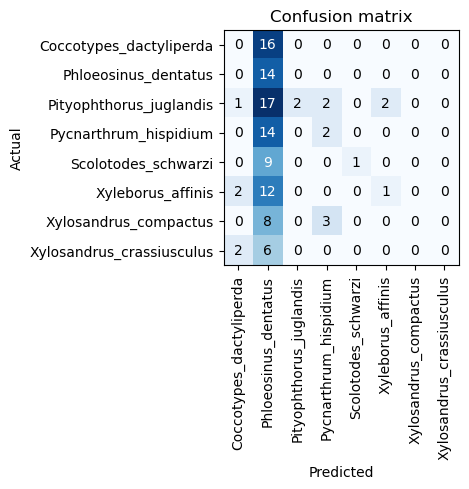

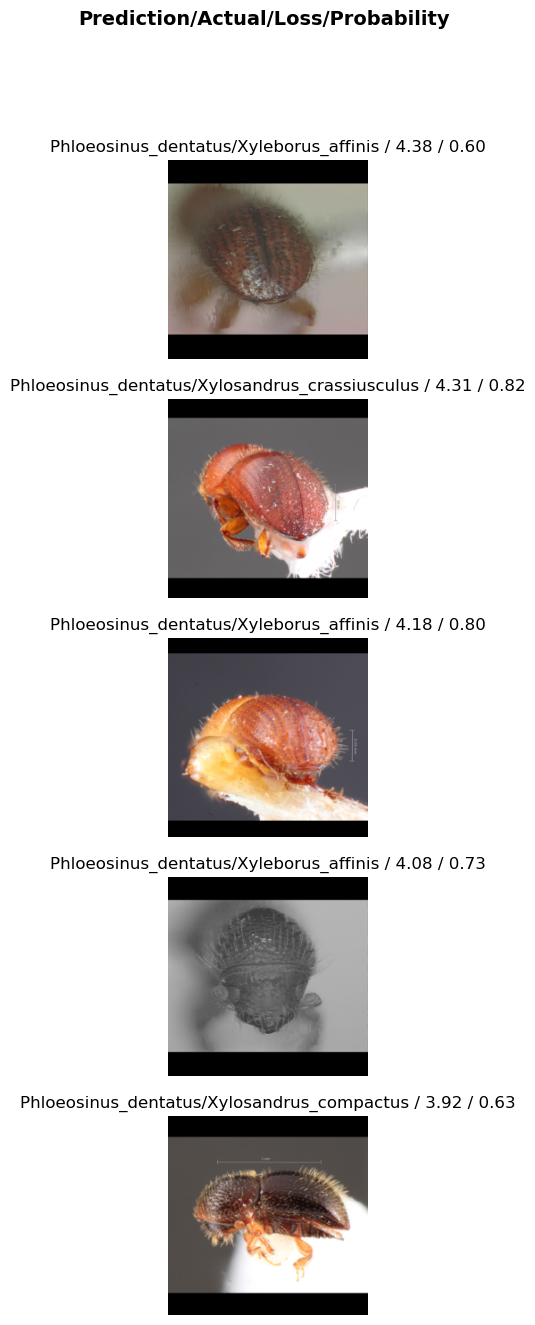

In [3]:
train(config=config, dataset_path=r"F:\selected_images\atkinson_data")